In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

from pycox.datasets import metabric
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
from pycox.preprocessing.feature_transforms import OrderedCategoricalLong

In [2]:
# We also set some seeds to make this reproducable.
np.random.seed(42)
_ = torch.manual_seed(42)

## Dataset


In [3]:
path_to_file = './../dataset_and_other_models/dataset/'
df_train_x = pd.read_csv(path_to_file + 'train_x.csv')
df_train_y = pd.read_csv(path_to_file + 'train_y.csv')
df_train_y['Status'].replace({True: 1, False: 0}, inplace=True)

In [4]:
df_test_x = pd.read_csv(path_to_file + 'test_x.csv')
df_test_y = pd.read_csv(path_to_file + 'test_y.csv')
df_test_y['Status'].replace({True: 1, False: 0}, inplace=True)

In [5]:
df_test = pd.concat([df_test_x, df_test_y], axis=1)
df_test = df_test.astype('float32')

In [6]:
df_train = pd.concat([df_train_x, df_train_y], axis=1)
df_train = df_train.astype('float32')

In [7]:
df_val = df_train.sample(frac=0.25)
df_train = df_train.drop(df_val.index)

In [8]:
cols_standardize =  ['BE', 'BC', 'AY', 'Age'] # Numerical columns
cols_leave = ['Y', 'AF', 'BG', 'BH', 'BI', 'BL',
              'BM', 'BP', 'CY', 'DC',
              'DW', 'DX', 'DY', 'metastasis', 'secondprim'] # Binary columns
cols_categorical =  ['AQ', 'DE'] # Categorical Columns

print(len(cols_standardize) + len(cols_leave) + len(cols_categorical))

21


In [9]:
# Turn them to binary features (0, 1)
df_train[cols_leave] -= 1
df_val[cols_leave] -= 1
df_test[cols_leave] -= 1

In [10]:
df_train.head()

,Y,AF,AQ,AY,BC,BE,BG,BH,BI,BL,...,DC,DE,DW,DX,DY,Age,metastasis,secondprim,Status,Survival
1,1.0,1.0,1.0,4.0,2.5,3.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,59.0,1.0,1.0,1.0,219.0
2,1.0,1.0,2.0,2.0,1.5,3.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,1.0,66.0,1.0,1.0,0.0,645.0
3,1.0,0.0,2.0,2.0,3.0,2.0,0.0,0.0,1.0,0.0,...,1.0,10.0,1.0,1.0,1.0,72.0,1.0,1.0,0.0,2006.0
4,1.0,0.0,2.0,3.0,2.0,1.0,0.0,0.0,1.0,0.0,...,1.0,10.0,1.0,1.0,1.0,51.0,1.0,1.0,0.0,1933.0
6,1.0,1.0,2.0,2.0,2.7,2.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,55.0,1.0,1.0,1.0,435.0


In [11]:
# Preprocess different types of features.
standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]
categorical = [(col, OrderedCategoricalLong(min_per_category=5)) for col in cols_categorical]

x_mapper_float = DataFrameMapper(standardize + leave)
x_mapper_long = DataFrameMapper(categorical)  # we need a separate mapper to ensure the data type 'int64'

In [12]:
x_fit_transform = lambda df: tt.tuplefy(x_mapper_float.fit_transform(df), x_mapper_long.fit_transform(df))
x_transform = lambda df: tt.tuplefy(x_mapper_float.transform(df), x_mapper_long.transform(df))

In [13]:
x_train = x_fit_transform(df_train)
x_val = x_transform(df_val)
x_test = x_transform(df_test)

In [14]:
df_train['AQ'].head(10)

1      1.0
2      2.0
3      2.0
4      2.0
6      2.0
7      6.0
8      2.0
10     1.0
11     2.0
12    10.0
Name: AQ, dtype: float32

In [15]:
print(x_train.shapes(), x_val.shapes(), x_test.shapes())

((315, 19), (315, 2)) ((105, 19), (105, 2)) ((106, 19), (106, 2))


In [16]:
get_target = lambda df: (df['Survival'].values, df['Status'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = x_val, y_val

## Neural Network

In [17]:
np.std(x_train[0][:, 0])
x_train[1]

array([[1, 1],
       [2, 1],
       [2, 9],
       [2, 9],
       [2, 1],
       [5, 7],
       [2, 2],
       [1, 3],
       [2, 1],
       [0, 8],
       [2, 1],
       [2, 9],
       [2, 1],
       [2, 1],
       [2, 9],
       [5, 1],
       [2, 9],
       [2, 9],
       [3, 9],
       [4, 9],
       [2, 2],
       [2, 2],
       [2, 1],
       [5, 9],
       [4, 9],
       [1, 1],
       [1, 1],
       [2, 9],
       [2, 9],
       [2, 9],
       [0, 1],
       [1, 9],
       [2, 5],
       [2, 2],
       [2, 1],
       [2, 1],
       [2, 8],
       [2, 9],
       [2, 8],
       [1, 8],
       [4, 1],
       [2, 9],
       [5, 9],
       [5, 2],
       [4, 9],
       [2, 2],
       [2, 9],
       [1, 9],
       [4, 1],
       [1, 9],
       [0, 9],
       [2, 9],
       [5, 2],
       [4, 9],
       [2, 9],
       [1, 1],
       [2, 3],
       [0, 1],
       [1, 9],
       [2, 6],
       [5, 8],
       [4, 1],
       [1, 9],
       [1, 3],
       [2, 9],
       [2, 7],
       [5,

In [18]:
num_embeddings = x_train[1].max(0) + 1
embedding_dims = num_embeddings // 2

In [19]:
num_embeddings, embedding_dims

(array([ 6, 10], dtype=int64), array([3, 5], dtype=int64))

In [179]:
# {'num_nodes': [32, 16, 16, 16, 32], 'dropout': 0.7, 'lr': 0.05}
# {'Validation Error': -3.275776, 'VE': -1.1813684, 'Train Error': -4.036133}

# Opt1: {'num_nodes': [64, 128, 128, 64], 'dropout': 0.7, 'lr': 0.05}
# Opt2: {'num_nodes': [32, 16, 16, 16, 32], 'dropout': 0.8, 'lr': 0.05}
# Opt3: {'num_nodes': [64, 64, 64], 'dropout': 0.6, 'lr': 0.05}
# Opt4: {'num_nodes': [64, 64], 'dropout': 0.6, 'lr': 0.01}
# Opt3: {'num_nodes': [64, 128, 64], 'dropout': 0.6, 'lr': 0.05}

in_features = x_train[0].shape[1]
num_nodes =  [64, 64, 64]
out_features = 1
batch_norm = True
dropout = 0.6
output_bias = False

net = tt.practical.MixedInputMLP(in_features, num_embeddings, embedding_dims,
                                 num_nodes, out_features, batch_norm, dropout)

In [180]:
in_features

19

In [181]:
net

MixedInputMLP(
  (embeddings): EntityEmbeddings(
    (embeddings): ModuleList(
      (0): Embedding(6, 3)
      (1): Embedding(10, 5)
    )
  )
  (mlp): MLPVanilla(
    (net): Sequential(
      (0): DenseVanillaBlock(
        (linear): Linear(in_features=27, out_features=64, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.6, inplace=False)
      )
      (1): DenseVanillaBlock(
        (linear): Linear(in_features=64, out_features=64, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.6, inplace=False)
      )
      (2): DenseVanillaBlock(
        (linear): Linear(in_features=64, out_features=64, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        

## Training the model

In [182]:
model = CoxPH(net, tt.optim.Adam)

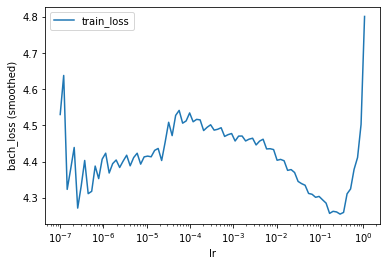

In [183]:
batch_size = 128
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()

In [184]:
lrfinder.get_best_lr()

0.029150530628251937

In [185]:
model.optimizer.set_lr(0.01)
# model.optimizer.set_lr(0.05)

In [186]:
# epochs = 512
epochs = 400
# callbacks = [tt.callbacks.EarlyStopping()]
callbacks = []
verbose = False

In [187]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)


Wall time: 8.2 s


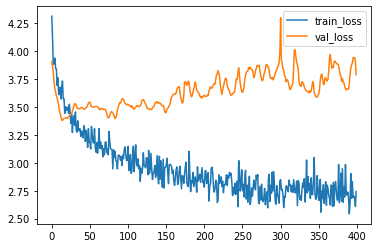

In [188]:
_ = log.plot()

We can get the partial log-likelihood

In [189]:
model.partial_log_likelihood(*val).mean()

-3.7915719

In [190]:
my_train = x_train, y_train
model.partial_log_likelihood(*my_train).mean()

-3.4709425

## Prediction

In [191]:
_ = model.compute_baseline_hazards()

In [192]:
surv = model.predict_surv_df(x_test)
surv_train = model.predict_surv_df(x_train)
surv_val = model.predict_surv_df(x_val)

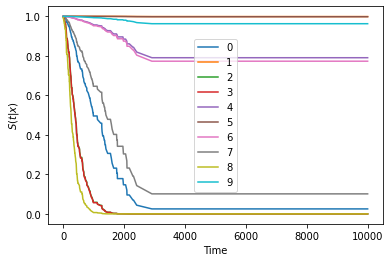

In [195]:
surv.iloc[:, 0:10].plot()
plt.ylabel('$S(t|x)$')
_ = plt.xlabel('Time')

## Evaluation

In [196]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
ev.concordance_td()

0.8227804542326221

In [197]:
durations_train, events_train = get_target(df_train)
ev_train = EvalSurv(surv_train, durations_train, events_train, censor_surv='km')
ev_train.concordance_td()

0.9374611076540137

In [198]:
durations_val, events_val = get_target(df_val)
ev_val = EvalSurv(surv_val, durations_val, events_val, censor_surv='km')
ev_val.concordance_td()

0.797377830750894

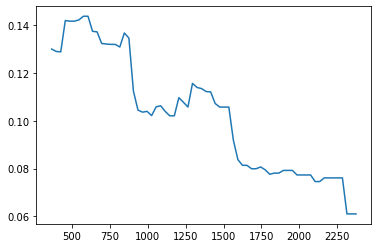

In [199]:
# time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
time_grid = np.arange(365, 2400, 30)
_ = ev.brier_score(time_grid).plot()

In [200]:
ev.integrated_brier_score(time_grid)

0.10246908514747206

In [201]:
ev_train.integrated_brier_score(time_grid)

0.03839472103854842

In [202]:
ev_val.integrated_brier_score(time_grid)

0.10792015866379481

In [22]:
in_features = x_train[0].shape[1]
out_features = 1

my_train = x_train, y_train

nets = [[32, 32, 32, 32], [64, 128, 128, 64], [64, 64, 64, 64], [32, 32, 32], [16, 16, 16], [64, 64, 64], [32, 32], [16, 16], [64, 64],
       [32, 16, 16, 16, 32]]
droputs = [0.6, 0.7, 0.8, 0.65]
lrs = [0.01, 0.05]

batch_size = 128
epochs = 512
callbacks = [] #[tt.cb.EarlyStoppingCycle(min_delta=0, patience=10,)]
verbose = False

cv = []

for num_nodes in nets:
    for dropout in droputs:
        for lr in lrs:       
            params = {'num_nodes': num_nodes, 'dropout': dropout, 'lr': lr}
            print(params)
            batch_norm = True
            net = tt.practical.MixedInputMLP(in_features, num_embeddings, embedding_dims,
                                 num_nodes, out_features, batch_norm, dropout)
            
            model = CoxPH(net, tt.optim.Adam)
            
            model.optimizer.set_lr(lr)
            
            log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose=0, val_data=val, val_batch_size=batch_size)
            
            score = {'Validation Error': model.partial_log_likelihood(*val).mean(), 'VE': model.partial_log_likelihood(*val).max(), 'Train Error': model.partial_log_likelihood(*my_train).mean()}
            print(score)
            
            cv.append([params, score['Validation Error'], score['VE']])
            
            print('---------------')


{'num_nodes': [32, 32, 32, 32], 'dropout': 0.6, 'lr': 0.01}
{'Validation Error': -3.709172, 'VE': -1.1304665, 'Train Error': -3.8396063}
---------------
{'num_nodes': [32, 32, 32, 32], 'dropout': 0.6, 'lr': 0.05}
{'Validation Error': -3.6841455, 'VE': -1.7970791, 'Train Error': -3.8960547}
---------------
{'num_nodes': [32, 32, 32, 32], 'dropout': 0.7, 'lr': 0.01}
{'Validation Error': -3.6977487, 'VE': -1.4552667, 'Train Error': -4.0763874}
---------------
{'num_nodes': [32, 32, 32, 32], 'dropout': 0.7, 'lr': 0.05}
{'Validation Error': -3.6727424, 'VE': -1.7387218, 'Train Error': -4.257195}
---------------
{'num_nodes': [32, 32, 32, 32], 'dropout': 0.8, 'lr': 0.01}
{'Validation Error': -3.6947987, 'VE': -1.6030993, 'Train Error': -4.3614697}
---------------
{'num_nodes': [32, 32, 32, 32], 'dropout': 0.8, 'lr': 0.05}
{'Validation Error': -3.6611133, 'VE': -1.6615419, 'Train Error': -4.3762913}
---------------
{'num_nodes': [32, 32, 32, 32], 'dropout': 0.65, 'lr': 0.01}
{'Validation Erro

In [44]:
with open('hyperparameters_DS.npy', 'wb') as f:
    np.save(f, np.array(cv))
    

In [ ]:
{'num_nodes': [32, 16, 16, 16, 32], 'dropout': 0.7, 'lr': 0.05}
{'Validation Error': -3.275776, 'VE': -1.1813684, 'Train Error': -4.036133}, 90

{'num_nodes': [32, 16, 16, 16, 32], 'dropout': 0.7, 'lr': 0.01}
{'Validation Error': -3.2171524, 'VE': -1.3644053, 'Train Error': -4.0101156}, 0.8022700119474313 OK

{'num_nodes': [64, 64], 'dropout': 0.8, 'lr': 0.001}
{'Validation Error': -3.165941, 'VE': -1.4364513, 'Train Error': -4.0623207}, 0.7956989247311828

{'num_nodes': [64, 64], 'dropout': 0.6, 'lr': 0.001}
{'Validation Error': -3.1862323, 'VE': -1.0430977, 'Train Error': -3.4072099}, 0.7915173237753883 OVERFIT

{'num_nodes': [64, 64, 64], 'dropout': 0.6, 'lr': 0.001}
{'Validation Error': -3.228777, 'VE': -1.1623064, 'Train Error': -3.549018}, 0.75

#-----------

{'num_nodes': [64, 64, 64], 'dropout': 0.6, 'lr': 0.05}
{'Validation Error': -4.53501, 'VE': -1.1080627, 'Train Error': -2.9832726}

{'num_nodes': [64, 64], 'dropout': 0.6, 'lr': 0.01}
{'Validation Error': -4.6100264, 'VE': -0.5832329, 'Train Error': -2.8363776}

{'num_nodes': [64, 64], 'dropout': 0.6, 'lr': 0.05}
{'Validation Error': -5.997805, 'VE': -0.66173744, 'Train Error': -2.9584057}

{'num_nodes': [32, 16, 16, 16, 32], 'dropout': 0.8, 'lr': 0.01}
{'Validation Error': -3.8601236, 'VE': -3.0478382, 'Train Error': -4.972593}

#--------
{'num_nodes': [32, 16, 16, 16, 32], 'dropout': 0.8, 'lr': 0.05}
{'num_nodes': [32, 16, 16, 16, 32], 'dropout': 0.8, 'lr': 0.01}
{'num_nodes': [64, 64, 64], 'dropout': 0.6, 'lr': 0.05}
{'num_nodes': [64, 128, 128, 64], 'dropout': 0.65, 'lr': 0.05}
{'num_nodes': [64, 64], 'dropout': 0.6, 'lr': 0.05}